# Twitter US Airline Sentiment

## Background
Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

## Objective
To build a classification model to analyse the sentiments expressed by customers in relation to service experiences with a US airline. The process of building the model should demonstrate pre-processing, then building and evaluating a classification model.

## Data Description
The project brief requires the use of a dataset from Kaggle (https://www.kaggle.com/crowdflower/twitter-airline-sentiment). The brief specifies that the dataset contains the following columns; tweet_id, airline_sentiment, airline_sentiment_confidence, negativereason, negativereason_confidence, airline, airline_sentiment_gold, name, negativereason_gold, retweet_count, text, tweet_coord, tweet_created, tweet_location, user_timezone

(this notebook loaded to GitHub at https://github.com/GreatLearningAIML1/gl-pgp-aiml-uta-intl-may20-pierssmith/tree/master/Week%2025%20-%20Project%20-%20NLP)

#  
---
# Deliverable 1
---

## 1.1 Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Dataframe & math
import pandas as pd
import pandas_profiling
import numpy as np

# Visualisations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Pre-processing
import re
import unicodedata
import contractions
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from ekphrasis.classes.segmenter import Segmenter
from wordcloud import WordCloud

# Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Model building
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelBinarizer
import itertools

## 1.2 Load dataset

In [2]:
df_abt_CustomerTweets = pd.read_csv('Tweets.csv')

## 1.3 Data shape and description

In [3]:
print(df_abt_CustomerTweets.shape)

(14640, 15)


In [4]:
pandas_profiling.ProfileReport(df_abt_CustomerTweets)

According to the project brief and the dataset description, the expected columns are tweet_id, airline_sentiment, airline_sentiment_confidence, negativereason, negativereason_confidence, airline, airline_sentiment_gold, name, negativereason_gold, retweet_count, text, tweet_coord, tweet_created, tweet_location, user_timezone. These are all observed in the dataset.

The project brief calls for all but two of the columns to be dropped to produce the analysis dataset, so there is no real value in an exhaustive EDA of the columns that will be dropped.

In terms of the two columns being retained for this analysis, both 'text' and 'airline_sentiment' contain no null values. The 'airline_sentiment' column is a categorical variable containing three distinct values - negative, neutral, and positive.

In [5]:
df_abt_CustomerTweets[['airline_sentiment', 'text']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


In [6]:
df_abt_CustomerTweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

However, the profile report shows there are 36 duplicate rows in the dataset. Given the dataset includes a timestamp for each tweet (tweet_created), as well as the username, the text of the tweet, and an identifier, these would seem to be clearly duplicated records for a single tweet. As such, the duplicates will be dropped, but retaining the first record.

In [7]:
duplicatedTweets = df_abt_CustomerTweets[df_abt_CustomerTweets.duplicated()]
print(duplicatedTweets)

                 tweet_id airline_sentiment  airline_sentiment_confidence  \
12040  570308309682675712          negative                           1.0   
12059  570305051819941889           neutral                           1.0   
12063  570303383782989824           neutral                           1.0   
12066  570301929580048385           neutral                           1.0   
12068  570301395141836801          negative                           1.0   
12069  570300915418320897          negative                           1.0   
12074  570299252141903873          positive                           1.0   
12075  570298770136674304          negative                           1.0   
12078  570298644475346945          negative                           1.0   
12079  570298371140939776          negative                           1.0   
12086  570296996445204480          negative                           1.0   
12093  570295576446808065          negative                           1.0   

In [8]:
df_abt_CustomerTweets.drop_duplicates(keep='first', inplace=True)
print(df_abt_CustomerTweets.shape)

(14604, 15)


Finally, it's worth a brief examination of the distribution of the 'airline_sentiment' categorical variable, as any observed class imbalance may give some insights later to the performance of the model. From the value_counts result shown above, the dataset contains 9178 tweets that were assessed as negative, against only 3099 that were neutral and 2363 that were positive.

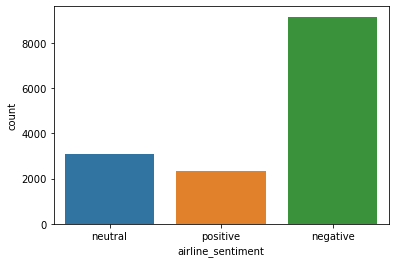

In [9]:
sns.countplot(df_abt_CustomerTweets['airline_sentiment']);

#  
---
# Deliverable 2
---

## 2.1 Drop all columns except "text" and "airline_sentiment"

To do this non-destructively on the raw dataset, instead of dropping all other columns we'll simply create a new working dataframe selectively with the two specified columns.

In [10]:
df_working_CustomerTweets = df_abt_CustomerTweets[["text", "airline_sentiment"]].copy()

## 2.2 Data shape

In [11]:
print(df_working_CustomerTweets.shape)

(14604, 2)


## 2.3 First 5 rows

In [12]:
df_working_CustomerTweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


#  
---
# Deliverable 3
---

## 3.1 Preprocessing

Before settling on the pre-processing strategy, it's useful to examine the text data that will be pre-processed, particularly for data like tweets, where there are a number of formatting and punctuation devices that are used regularly in social media, such as hashtags and emojis.

In [13]:
pd.set_option('display.max_colwidth', 150)
df_abt_CustomerTweets[['text']].head(30)

,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials to the experience... tacky.
2,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,@VirginAmerica and it's a really big bad thing about it
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
8,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."


A few observations emerge from this sample of data. 

The first is the number of tweets that are using three-letter abbreviations when referring to flight routes, such as "LAX to MCO". The issue with some of these is that when they are converted to lowercase, they are words that will appear in the English corpus - for example, LAX when converted to lowercase is 'lax', which in English means 'not sufficiently strict, severe, or careful'. Given how much flight traffic goes in and out of LAX, it's not hard to see how this could have an unintentional effect on the model - especially as it would dilute the effect of people intentionally using 'lax' in their tweet (e.g. 'there were lax security arrangements at the aiport').

The second is that all the tweets either begin with or contain a Twitter username (beginning with '@'), usually the airline to whom the tweet is being directed.

Finally, there are tweets observed in this sample where hashtags are being used in a way that communicates sentiment - either negative (e.g. '#worstflightever') or positive (e.g. '#fabulous').

So, my pre-processing strategy is going to include three additional steps. Firstly, removing IATA codes from the tweets (flight routes and airport names do not contribute to understanding sentiment, and as noted above they can actually introduce unintended sentiments when the lowercase versions correspond to real words), secondly dropping Twitter usernames, and finally selectively processing hashtags (noting that tags like #worstflightever are compound words that will require splitting).

The project deliverables called for pre-processing to include (a) HTML tag removal, (b) Tokenization, (c) Remove numbers, (d) Remove special characters & punctuation, (e) Convert to lowercase, (f) Lemmatisation/Stemming, and (g) Convert to string. These are all implemented below.

### 3.1.1 Define preprocessing functions

In [14]:
# The custom function to remove IATA codes is using an open source dataset of airport data,
# trimmed to the IATA codes.
df_abt_IATACodes = pd.read_csv('airport-codes-iataonly_csv.csv')
iataCodes = set(df_abt_IATACodes['iata_code'])

# Also loading the words corpus from nltk to assist with hashtag splitting, and loading
# the stopwords set.
wordsCorpus = set(nltk.corpus.words.words())
stopWords = set(stopwords.words("english"))

In [15]:
# Define the functions for each preprocessing step

def normalizeAndLowercase(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_word = new_word.lower()
        new_words.append(new_word)
    return new_words

def removeNoise(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^a-zA-z\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def removeStopWords(words):
    new_words = [] 
    for word in words:
        if word not in stopWords:
            new_words.append(word)        
    return new_words
    
def removeWordsNotInCorpus(words):
    new_words = [] 
    for word in words:
        if word in wordsCorpus:
            new_words.append(word)
    return new_words

def lemmatizeWords(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []                           
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)              
    return lemmas

def removeIATACodes(words):
    new_words = []
    for word in words:
        if word not in iataCodes:
            new_words.append(word)
    return new_words

In [16]:
# Finally, define the parent functions that implement the preprocessing steps in order. The
# function 'preProcessTweet' is called iteratively when processing the dataset, and for each
# tweet it removes HTML and hyperlinks, fixes word contractions, removes Twitter usernames,
# then tokenizes the tweet using the TweetTokenizer in nltk - this preserves hashtags in the
# tokens. The tweet is then parsed to separate hashtags from the tweet, so the hashtags can be
# selectively processed using the ekphrasis Segmenter, which attempts to segment compound words
# according to whether the fragments are present in the dictionary. A further data quality step
# lemmatizes the words and checks if they are present in the words corpus before adding them to
# the string. Finally, all the strings are preprocessed, to remove IATA codes, normalize and
# convert to lowercase, remove noise and stopwords, then lemmatize and return. This implements
# all the required preprocessing steps in the project brief, and the additional Twitter-specific
# preprocessing steps identified in the preamble analysis above.

tt = TweetTokenizer()
seg_tw = Segmenter(corpus="twitter")

def preProcessTweet(tweet):
    # 1 Remove HTML and remove links
    soup = BeautifulSoup(tweet, "html.parser")
    cleanedTweet = soup.get_text()

    cleanedTweet = re.sub(r'http\S+', '', cleanedTweet)

    # 2 Fix contractions
    cleanedTweet = contractions.fix(cleanedTweet)

    # 3 Remove usernames
    cleanedTweet = re.sub('@[^\s]+','', cleanedTweet)
    
    # 4 Tweet tokenize and parse text & hashtags
    tokenizedTweet = tt.tokenize(cleanedTweet)
    tweetText, tweetHashtags = parseTweet(tokenizedTweet)
    
    hashtagString = parseHashtags(tweetHashtags)
    tweetString = ( " ".join( tweetText ))
    
    processedHashtags = processTweetString(hashtagString)
    processedText = processTweetString(tweetString)
    
    return processedText + ' ' + processedHashtags

def parseTweet(tweetTokens):
    tweetHashtags = []
    tweetText = []
    for token in tweetTokens:
        if token[0] == '#':
            tweetHashtags.append(token[1:])
        else:
            tweetText.append(token)
    return tweetText, tweetHashtags
        
def processTweetString(tweetString):
    
    cleanedString = re.sub('[^\w]|[\d_]', ' ', tweetString)
    tokenizedString = nltk.word_tokenize(cleanedString)
    
    tokenizedString = removeIATACodes(tokenizedString)
    
    tokenizedString = normalizeAndLowercase(tokenizedString)
    tokenizedString = removeNoise(tokenizedString)
    tokenizedString = removeStopWords(tokenizedString)
    tokenizedString = lemmatizeWords(tokenizedString)
    tokenizedString = removeWordsNotInCorpus(tokenizedString)
    
    return ( " ".join( tokenizedString ))

def parseHashtags(hashtags):
    newTags = []
    for tag in hashtags:
        segmentedHashtag = (seg_tw.segment(tag)).split()
        segmentedHashtag = lemmatizeWords(segmentedHashtag)
        segmentedHashtag = removeWordsNotInCorpus(segmentedHashtag)
        parsedHashtag = ( " ".join( segmentedHashtag ))
        newTags.append(parsedHashtag)
        
    return ( " ".join( newTags ))


def parseTweet(tweetTokens):
    tweetHashtags = []
    tweetText = []
    for token in tweetTokens:
        if token[0] == '#':
            tweetHashtags.append(token[1:])
        else:
            tweetText.append(token)
    return tweetText, tweetHashtags


Reading twitter - 1grams ...
Reading twitter - 2grams ...


### 3.1.2 Preprocess a sample

In [17]:
# Before preprocessing the entire dataset, examine the effect on two candidate tweet strings
# and observe the results.

In [18]:
df_TweetComparison = pd.DataFrame(columns=['Original', 'Preprocessed'])
sampleIndexes = [3, 28]
i=0

for index in sampleIndexes:
    sampleTweet = df_abt_CustomerTweets.iloc[index]['text']
    processedSample = preProcessTweet(sampleTweet)
    df_TweetComparison.loc[i] = [sampleTweet, processedSample]
    i+=1

df_TweetComparison

,Original,Preprocessed
0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",really aggressive blast obnoxious entertainment face little recourse
1,@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS,amaze get cold air vent air worst flight ever roast


This shows the effect of the preprocessing strategy, with the three additional steps identified in the earlier analysis. The Twitter usernames have been dropped, the hashtags have been parsed, and the IATA codes dropped (further, where the hashtag did not contain real words, like #VK358, this has been dropped).

### 3.1.3 Preprocess the dataset

In [19]:
for i, row in df_working_CustomerTweets.iterrows():
    df_working_CustomerTweets.at[i, 'text'] = preProcessTweet(df_working_CustomerTweets.at[i, 'text'])

## 3.2 First 5 rows

In [20]:
pd.set_option('display.max_colwidth', 100)
df_working_CustomerTweets.head(5)

,text,airline_sentiment
0,say,neutral
1,plus add experience tacky,positive
2,today must mean need take another trip,neutral
3,really aggressive blast obnoxious entertainment face little recourse,negative
4,really big bad thing,negative


Having preprocessed the dataset, a word cloud is a useful visualisation of the result in terms of the words that appear most frequently for different sentiments. Here, we'll examine the word clouds for negative and positive sentiment. 

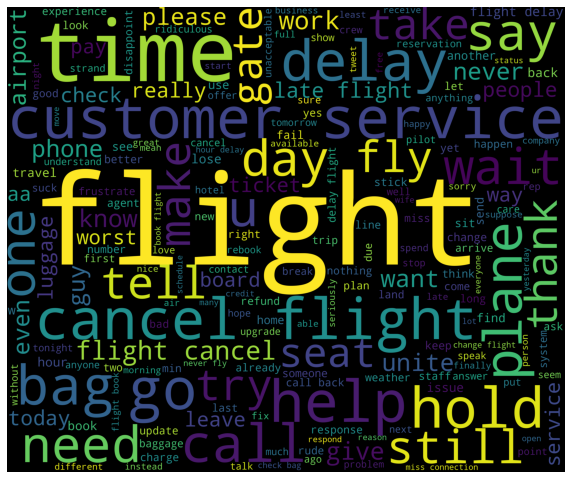

In [21]:
df=df_working_CustomerTweets[df_working_CustomerTweets['airline_sentiment']=='negative']
words = ' '.join(df['text'])
wordcloud = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(words)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

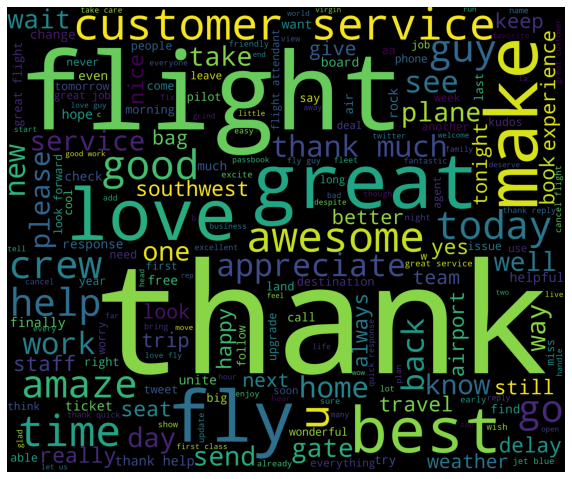

In [22]:
df=df_working_CustomerTweets[df_working_CustomerTweets['airline_sentiment']=='positive']
words = ' '.join(df['text'])
wordcloud = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(words)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

One result that is immediately apparent is that 'flight' appears prominently in tweets that were classified as negative and as positive. As well as being a common word, this is pointing to where we may observe different results for the two models of vectorization to be considered as part of the project brief.

#  
---
# Deliverable 4
---

Before vectorizing, separate the dataframe containing the preprocessed tweets and the sentiment labels into two arrays for model building.

In [23]:
preprocessedTweets = df_working_CustomerTweets['text'].values
sentimentLabels = df_working_CustomerTweets['airline_sentiment'].values

In [24]:
preprocessedTweets

array(['say ', 'plus add experience tacky ',
       'today must mean need take another trip ', ...,
       'please bring black berry',
       'money change flight answer phone make commitment ',
       'need know many seat next flight put us people next flight '],
      dtype=object)

In [25]:
sentimentLabels

array(['neutral', 'positive', 'neutral', ..., 'neutral', 'negative',
       'neutral'], dtype=object)

## 4.1 Vectorisation (CountVectorizer)

In [26]:
cvVectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, max_features = 2500) 

countVectorizedFeatures = cvVectorizer.fit_transform(preprocessedTweets).toarray()
countVectorizedFeatures

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [27]:
print (countVectorizedFeatures.shape)

(14604, 2500)


In [28]:
countvecVocabulary = cvVectorizer.get_feature_names()
print (countvecVocabulary)

['aa', 'abandon', 'ability', 'able', 'aboard', 'absolute', 'absolutely', 'absurd', 'abuse', 'abysmal', 'accept', 'acceptable', 'access', 'accident', 'accidentally', 'accommodate', 'accomplish', 'accord', 'accordingly', 'account', 'accountability', 'accurate', 'achieve', 'acknowledge', 'acquire', 'across', 'act', 'action', 'active', 'actual', 'actually', 'ad', 'add', 'addition', 'additional', 'address', 'admiral', 'admit', 'adopt', 'adore', 'advance', 'advantage', 'advertise', 'advice', 'advise', 'advisory', 'affair', 'affect', 'affiliate', 'afford', 'affordable', 'afternoon', 'age', 'agency', 'agent', 'aggravate', 'aggressive', 'ago', 'agree', 'ah', 'ahead', 'air', 'aircraft', 'airplane', 'airport', 'aisle', 'aka', 'alert', 'alive', 'allergy', 'alliance', 'allow', 'allowance', 'almost', 'alone', 'along', 'already', 'alright', 'also', 'alternate', 'alternative', 'although', 'altitude', 'always', 'amateurish', 'amaze', 'among', 'amount', 'anchorage', 'android', 'angel', 'angry', 'anniver

## 4.2 Vectorisation (TfidfVectorizer)

In [29]:
tfiVectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8)

tfidfVectorizedFeatures = tfiVectorizer.fit_transform(preprocessedTweets).toarray()
tfidfVectorizedFeatures

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
print (tfidfVectorizedFeatures.shape)

(14604, 1443)


In [31]:
tfidfVocabulary = tfiVectorizer.get_feature_names()
print (tfidfVocabulary)

['aa', 'able', 'absolute', 'absolutely', 'absurd', 'accept', 'acceptable', 'access', 'accommodate', 'accord', 'account', 'accurate', 'across', 'act', 'action', 'actual', 'actually', 'add', 'additional', 'address', 'advance', 'advantage', 'advertise', 'advice', 'advise', 'advisory', 'affect', 'afford', 'afternoon', 'age', 'agent', 'ago', 'agree', 'ah', 'ahead', 'air', 'aircraft', 'airplane', 'airport', 'alert', 'alliance', 'allow', 'almost', 'alone', 'along', 'already', 'alright', 'also', 'alternate', 'although', 'always', 'amaze', 'among', 'amount', 'angry', 'anniversary', 'announce', 'announcement', 'annoy', 'another', 'answer', 'anyone', 'anything', 'anyway', 'anywhere', 'apart', 'apologize', 'apology', 'apparently', 'appear', 'appease', 'apple', 'apply', 'appreciate', 'approach', 'approve', 'area', 'argue', 'around', 'arrange', 'arrival', 'arrive', 'article', 'ashamed', 'ask', 'aspen', 'ass', 'assign', 'assignment', 'assist', 'assistance', 'assume', 'assure', 'atlantic', 'atrocious'

#  
---
# Deliverable 5
---

To evaluate the performance of the model, we'll first split the preprocessed and vectorized data in training and test sets. As the brief calls for both models of vectorization to be used and compared, we will perform two splits to produce train and test sets for the countVectorizedFeatures data and the tfidfVectorizedFeatures data.

In [32]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(countVectorizedFeatures, sentimentLabels, test_size=0.2, random_state=25)

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidfVectorizedFeatures, sentimentLabels, test_size=0.2, random_state=25)

## 5.1 Fit model

We'll first go for a quick model using RandomForest. As per the project brief, we will produce two classifiers, one for each model of vectorization.

In [33]:
cvClassifier = RandomForestClassifier(n_estimators=200, random_state=0)
cvClassifier.fit(X_train_cv, y_train_cv)

tfidfClassifier = RandomForestClassifier(n_estimators=200, random_state=0)
tfidfClassifier.fit(X_train_tfidf, y_train_tfidf)

RandomForestClassifier(n_estimators=200, random_state=0)

## 5.2 Evaluate

### 5.2.1 Evaluate the quick model

In [34]:
y_predict_cv = cvClassifier.predict(X_test_cv)
y_predict_tfidf = tfidfClassifier.predict(X_test_tfidf)

In [35]:
print("Classification Report - Count Vectorized")
print(classification_report(y_test_cv,y_predict_cv))
print(accuracy_score(y_test_cv, y_predict_cv))

Classification Report - Count Vectorized
              precision    recall  f1-score   support

    negative       0.82      0.89      0.86      1846
     neutral       0.60      0.50      0.55       611
    positive       0.69      0.61      0.64       464

    accuracy                           0.76      2921
   macro avg       0.70      0.67      0.68      2921
weighted avg       0.75      0.76      0.76      2921

0.764464224580623


In [36]:
print("Classification Report - TfIdf Vectorized")
print(classification_report(y_test_tfidf,y_predict_tfidf))
print(accuracy_score(y_test_tfidf, y_predict_tfidf))

Classification Report - TfIdf Vectorized
              precision    recall  f1-score   support

    negative       0.80      0.92      0.86      1846
     neutral       0.62      0.46      0.53       611
    positive       0.73      0.56      0.64       464

    accuracy                           0.77      2921
   macro avg       0.72      0.65      0.67      2921
weighted avg       0.75      0.77      0.75      2921

0.766175967134543


In [37]:
# Define a function to draw a confusion matrix, showing the sentiment labels for readability
enc = LabelBinarizer()
encodedLabels = enc.fit_transform(sentimentLabels)
enc.classes_

def drawConfusionMatrix(cm, classes, vectorizer):
    
    plt.figure(figsize=(8,8))
    plt.title('Tweet Sentiment Prediction Confusion Matrix: ' + vectorizer)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdYlGn)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="black")
                 
    plt.tight_layout()
    plt.ylabel('Actual Sentiment')
    plt.xlabel('Predicted Sentiment')

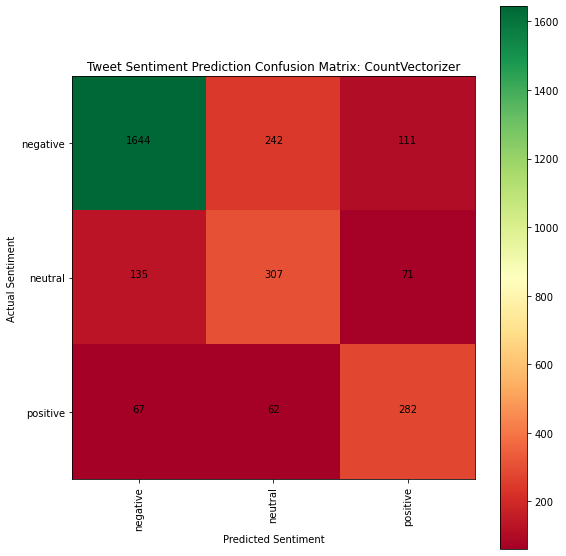

In [38]:
cm = confusion_matrix(y_predict_cv, y_test_cv)
drawConfusionMatrix(cm, enc.classes_, 'CountVectorizer') 

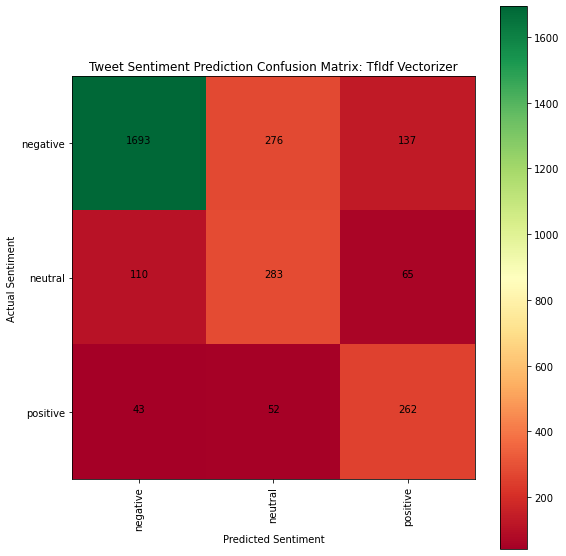

In [39]:
cm = confusion_matrix(y_predict_tfidf, y_test_tfidf)
drawConfusionMatrix(cm, enc.classes_, 'TfIdf Vectorizer') 

#### Observations

The overall accuracy of the models is very close, with the model built using the TfIdf vectorized data performing slightly better. What is evident is that the predictions for the negative class were significantly better than for the neutral and positive classes. Recalling the class imbalance that was observed during the EDA above, we will try some other models and also observe the effect of using the class_weight parameter.

### 5.2.2 Model tuning

In [40]:
random_state = [30]
class_weight = ['balanced']
n_estimators = [50, 100, 200]
criterion = ['entropy', 'gini']
hyperparameters = dict(random_state=random_state, n_estimators=n_estimators, criterion=criterion, class_weight=class_weight)

In [41]:
randomforest = RandomForestClassifier()
cvClassifier = GridSearchCV(randomforest, hyperparameters)
cvClassifier.fit(X_train_cv, y_train_cv)
y_predict_cv = cvClassifier.predict(X_test_cv)

In [42]:
randomforest = RandomForestClassifier()
tfidfClassifier = GridSearchCV(randomforest, hyperparameters)
tfidfClassifier.fit(X_train_tfidf, y_train_tfidf)
y_predict_tfidf = tfidfClassifier.predict(X_test_tfidf)

In [43]:
print("Classification Report - Count Vectorized")
print(classification_report(y_test_cv,y_predict_cv))
print(accuracy_score(y_test_cv, y_predict_cv))

Classification Report - Count Vectorized
              precision    recall  f1-score   support

    negative       0.83      0.88      0.85      1846
     neutral       0.60      0.52      0.56       611
    positive       0.66      0.62      0.64       464

    accuracy                           0.76      2921
   macro avg       0.70      0.67      0.68      2921
weighted avg       0.75      0.76      0.76      2921

0.7617254364943512


In [44]:
print("Classification Report - TfIdf Vectorized")
print(classification_report(y_test_tfidf,y_predict_tfidf))
print(accuracy_score(y_test_tfidf, y_predict_tfidf))

Classification Report - TfIdf Vectorized
              precision    recall  f1-score   support

    negative       0.81      0.91      0.86      1846
     neutral       0.62      0.50      0.55       611
    positive       0.72      0.59      0.65       464

    accuracy                           0.77      2921
   macro avg       0.72      0.66      0.68      2921
weighted avg       0.76      0.77      0.76      2921

0.7689147552208148


Running the RandomForestClassifier with some hyperparameter tuning has slightly improved the overall performance of the TfIdf model, but significantly the recall scores for neutral and positive sentiments have improved. Noting however that RandomForest is prone to overfitting, we'll examine the test and train scores.

In [45]:
train_score = round(tfidfClassifier.score(X_train_tfidf,y_train_tfidf),5)
test_score = round(tfidfClassifier.score(X_test_tfidf, y_test_tfidf), 5)

print('Train score: ' + str(train_score))
print('Test score: ' + str(test_score))

Train score: 0.98399
Test score: 0.76891


The model is significantly overfit, so for comparison we'll use the best parameters from the GridSearch and prune to a max_depth of 10 and compare the scores

In [46]:
max_depth = 20
criterion = tfidfClassifier.best_estimator_.get_params()['criterion']
n_estimators = tfidfClassifier.best_estimator_.get_params()['n_estimators']

tfidfClassifier_pruned = RandomForestClassifier(random_state=random_state[0], n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, class_weight=class_weight[0])
tfidfClassifier_pruned.fit(X_train_tfidf, y_train_tfidf)
y_predict_tfidf = tfidfClassifier_pruned.predict(X_test_tfidf)

train_score = round(tfidfClassifier_pruned.score(X_train_tfidf,y_train_tfidf),5)
test_score = round(tfidfClassifier_pruned.score(X_test_tfidf, y_test_tfidf), 5)

print('Train score: ' + str(train_score))
print('Test score: ' + str(test_score))

Train score: 0.76307
Test score: 0.69086


In [47]:
print("Classification Report - TfIdf Vectorized Pruned")
print(classification_report(y_test_tfidf,y_predict_tfidf))
print(accuracy_score(y_test_tfidf, y_predict_tfidf))

Classification Report - TfIdf Vectorized Pruned
              precision    recall  f1-score   support

    negative       0.88      0.71      0.78      1846
     neutral       0.42      0.69      0.52       611
    positive       0.66      0.63      0.65       464

    accuracy                           0.69      2921
   macro avg       0.65      0.67      0.65      2921
weighted avg       0.75      0.69      0.71      2921

0.6908592947620678


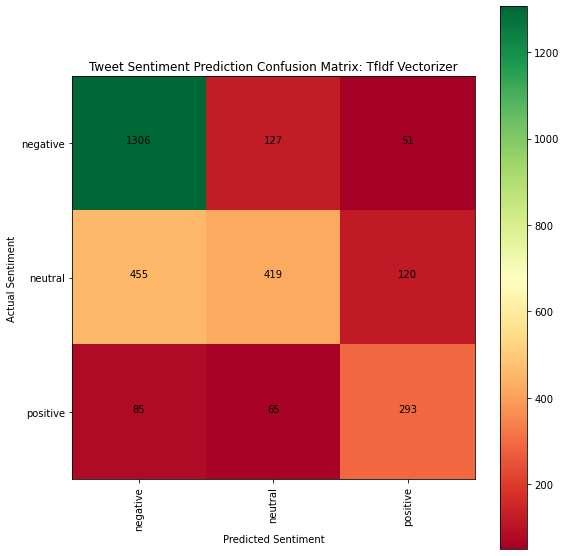

In [48]:
cm = confusion_matrix(y_predict_tfidf, y_test_tfidf)
drawConfusionMatrix(cm, enc.classes_, 'TfIdf Vectorizer') 

#  
---
# Deliverable 6
---

## 6.1 Summary

Pruning the hyperparameter-tuned random forest reduced the overfitting, but at the expense of overall accuracy for the model. However, a deeper inspection of the confusion matrix reveals some interesting results. For an airline business seeking to use sentiment analysis to understand customer sentiment and views, the problematic results are the off-diagonal results for positive and negative sentiment, and more particularly sentiments that are predicted to be positive but are actually negative - this is because if an airline was going to use sentiment analysis to follow up with an unhappy customer, and potentially turn around a bad experience, having customer tweets assessed as positive when they are actually negative means unhappy customers are not being reached. On this measure, the pruned model performed significantly better, with only 51 negative tweets being predicted as positive, down from 137 - this is also observed in the improved recall scores for positive sentiment. In terms of differences from the alternative vectorization strategies, the Tf-Idf vectorized model slightly outperformed the CountVectorised model. It's of note that although both vectorizers were set with a max_features argument of 2500, vectorizing with Tf-Idf did not reach this limit and produced a smaller feature set - this appears to have contributed to the better overall performance of the model, and better performance in the context of the business problem.